In [14]:
import numpy as np 
import matplotlib.pyplot as plt
fold = '/home/jy/Documents/fnirs/treatment_response/fnirs-depression-deeplearning/allData/prognosis/pre_treatment_hamd_reduction_50'

hb = np.load(fold + '/data.npy')
label = np.load(fold + '/label.npy')

print(hb.shape)

(65, 52, 2502)


In [10]:
import scipy.sparse as sp

def generate_fnirs_adj():
    matrix = sp.csr_matrix((52, 52), dtype=int)
    for i in range(10):
        if i > 0 and i < 9:
            matrix[i, i-1] = 1
            matrix[i, i+1] = 1
        elif i == 0:
            matrix[i, i+1] = 1
        else:
            matrix[i, i-1] = 1
        matrix[i, i+10] = 1
        matrix[i, i+11] = 1

    for i in range(10, 21):
        if i > 10 and i < 20:
            matrix[i, i-11] = 1
            matrix[i, i-10] = 1
            matrix[i, i-1] = 1
            matrix[i, i+1] = 1
            matrix[i, i+10] = 1
            matrix[i, i+11] = 1
        if i == 10:
            matrix[i, i-10] = 1
            matrix[i, i+1] = 1
            matrix[i, i+11] = 1
        if i == 20:
            matrix[i, i-11] = 1
            matrix[i, i-1] = 1
            matrix[i, i+10] = 1

    for i in range(21, 31):
        matrix[i, i-11] = 1
        matrix[i, i-10] = 1
        if i > 21 and i < 30:
            matrix[i, i-1] = 1
            matrix[i, i+1] = 1
        if i == 21:
            matrix[i, i+1] = 1

        if i == 30:
            matrix[i, i-1] = 1
        matrix[i, i+10] = 1
        matrix[i, i+11] = 1

    begin = 31
    end = 42

    for i in range(begin, end):
        if i > begin and i < end-1:
            matrix[i, i-11] = 1
            matrix[i, i-10] = 1
            matrix[i, i-1] = 1
            matrix[i, i+1] = 1
            matrix[i, i+10] = 1
            matrix[i, i+11] = 1
        if i == begin:
            matrix[i, i-10] = 1
            matrix[i, i+1] = 1
            matrix[i, i+11] = 1
        if i == end-1:
            matrix[i, i-11] = 1
            matrix[i, i-1] = 1
            matrix[i, i+10] = 1

    begin = 42
    end = 52

    for i in range(begin, end):
        if i > begin and i < end-1:
            matrix[i, i-11] = 1
            matrix[i, i-10] = 1
            matrix[i, i-1] = 1
            matrix[i, i+1] = 1
        if i == begin:
            matrix[i, i-11] = 1
            matrix[i, i-10] = 1
            matrix[i, i+1] = 1
        if i == end-1:
            matrix[i, i-11] = 1
            matrix[i, i-10] = 1
            matrix[i, i-1] = 1
    return matrix

adj = generate_fnirs_adj()
np_adj = adj.toarray()

all_folds = ['allData/prognosis/pre_post_treatment_hamd_reduction_50/',
             'allData/prognosis/pre_treatment_hamd_reduction_50/']
for fold in all_folds:
    label = np.load(fold + 'label.npy')
    print(label.shape)
    same_subject_of_adj = np.tile(np_adj, (label.shape[0],1,1))
    print(same_subject_of_adj.shape)
    # save to 
    np.save(fold+'adj_matrix', same_subject_of_adj)


(46,)
(46, 52, 52)


In [9]:
import importlib.util
import sys
import os 

print()

def get_config_from_filename(config_file_name):
    # Here is the path to your .py file
    file_path = os.getcwd() + '/configs/' + config_file_name 

    # Derive the module name from the file path
    module_name = 'config'
    # Add the directory containing the file to sys.path if it's not already included

    # Load the module from the file path
    spec = importlib.util.spec_from_file_location(module_name, file_path)
    config = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(config)
    return config

name = 'dmfc_pre_treatment_hamd_reduction_50_hbo_hbr.py'
config = get_config_from_filename(name)
print(config.INPUT_HB_TYPE)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/shanxiafeng/Documents/Project/Research/fnirs-prognosis/code/fnirs-treatment-response-prediction/scripts/test/configs/dmfc_pre_treatment_hamd_reduction_50_hbo_hbr.py'

In [2]:
# pre_post_treatment_hamd_reduction_50

data = np.load('/Users/shanxiafeng/Documents/Project/Research/fnirs-prognosis/code/fnirs-treatment-response-prediction/allData/prognosis/pre_post_treatment_hamd_reduction_50/data.npy')

print(data.shape)

(46, 52, 2502, 2)


# Test the function of stratified_f_fold_cross_validation_with_holdout 

In [31]:
def stratified_k_fold_cross_validation_with_holdout(data, label, k, num_of_k_fold, adj=None):
    total_amount = data.shape[0] 

    pos = data[label==1]
    neg = data[label==0]
    
    holdout_pos_num = pos.shape[0] // 3
    holdout_neg_num = neg.shape[0] // 3 
    
    X_test = np.concatenate((pos[:holdout_pos_num], neg[:holdout_neg_num]), axis=0)
    Y_test = np.concatenate((np.ones(holdout_pos_num), np.zeros(holdout_neg_num)), axis=0)
    
    train_val_pos = pos[holdout_pos_num:]
    train_val_neg = neg[holdout_neg_num:]

    """
    train_val_pos_num 
    - should be 10 for pretreatment dataset 
    - should be 8 for pre-post-treatment dataset 
    
    next, I will devide them by 2 to do 5 and 4 fold cross validation
    so the num_of_k_fold should be calulated by 
    (label==1).sum() * 2 / 3 / 2
    """
    train_val_pos_num = pos.shape[0]-holdout_pos_num 
    train_val_neg_num = neg.shape[0]-holdout_neg_num
    one_fold_number_pos = train_val_pos_num//num_of_k_fold
    one_fold_number_neg = train_val_neg_num//num_of_k_fold
    
    validation_pos = train_val_pos[k*one_fold_number_pos:(k+1)*one_fold_number_pos]
    validation_neg = train_val_neg[k*one_fold_number_neg:(k+1)*one_fold_number_neg]
    
    X_val = np.concatenate((validation_pos, validation_neg), axis=0)
    Y_val = np.concatenate((np.ones(validation_pos.shape[0]), np.zeros(validation_neg.shape[0])), axis=0)
    
    train_pos = np.concatenate((train_val_pos[0:k*one_fold_number_pos], train_val_pos[(k+1)*one_fold_number_pos:]), axis=0)
    train_neg = np.concatenate((train_val_neg[0:k*one_fold_number_neg], train_val_neg[(k+1)*one_fold_number_neg:]), axis=0)
    
    X_train = np.concatenate((train_pos, train_neg), axis=0)
    Y_train = np.concatenate((np.ones(train_pos.shape[0]), np.zeros(train_neg.shape[0])), axis=0)
    
    if adj is None:
        return X_train, Y_train, X_val, Y_val, X_test, Y_test
    else:
        raise NotImplementedError('adj is not implemented yet')

In [36]:
name = 'pre'
if name == 'pre':
    hb = np.load('/Users/shanxiafeng/Documents/Project/Research/fnirs-prognosis/code/fnirs-treatment-response-prediction/allData/prognosis/pre_treatment_hamd_reduction_50/data.npy')
    label = np.load('/Users/shanxiafeng/Documents/Project/Research/fnirs-prognosis/code/fnirs-treatment-response-prediction/allData/prognosis/pre_treatment_hamd_reduction_50/label.npy')

if name == 'pre_post':
    hb = np.load('/Users/shanxiafeng/Documents/Project/Research/fnirs-prognosis/code/fnirs-treatment-response-prediction/allData/prognosis/pre_post_treatment_hamd_reduction_50/data.npy')
    label = np.load('/Users/shanxiafeng/Documents/Project/Research/fnirs-prognosis/code/fnirs-treatment-response-prediction/allData/prognosis/pre_post_treatment_hamd_reduction_50/label.npy')

total_k_fold = int((label==1).sum() * 2 / 3 / 2)
print(total_k_fold)

for i in range(total_k_fold):
    X_train, Y_train, X_val, Y_val, X_test, Y_test = stratified_k_fold_cross_validation_with_holdout(hb, label, i, total_k_fold)

    print(i, X_train.shape, Y_train.shape, X_val.shape, Y_val.shape, X_test.shape, Y_test.shape)
    
    train_num = X_train.shape[0] + X_val.shape[0]
    test_num = X_test.shape[0]
    print(f'train: {train_num}, test:{test_num}')

5
0 (36, 52, 2502) (36,) (8, 52, 2502) (8,) (21, 52, 2502) (21,)
train: 44, test:21
1 (36, 52, 2502) (36,) (8, 52, 2502) (8,) (21, 52, 2502) (21,)
train: 44, test:21
2 (36, 52, 2502) (36,) (8, 52, 2502) (8,) (21, 52, 2502) (21,)
train: 44, test:21
3 (36, 52, 2502) (36,) (8, 52, 2502) (8,) (21, 52, 2502) (21,)
train: 44, test:21
4 (36, 52, 2502) (36,) (8, 52, 2502) (8,) (21, 52, 2502) (21,)
train: 44, test:21


(65, 52, 52)


Text(0.5, 1.0, 'HbT DMFC')

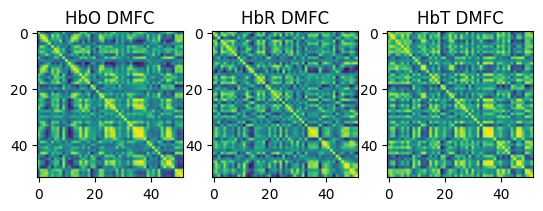

In [44]:
dmfc_hbo, dmfc_hbr, dmfc_hbt = np.load('/Users/shanxiafeng/Documents/Project/Research/fnirs-prognosis/code/fnirs-treatment-response-prediction/allData/prognosis/DMFC/hbo/pre_treatment_hamd_reduction_50/data.npy'), np.load('/Users/shanxiafeng/Documents/Project/Research/fnirs-prognosis/code/fnirs-treatment-response-prediction/allData/prognosis/DMFC/hbr/pre_treatment_hamd_reduction_50/data.npy'), np.load('/Users/shanxiafeng/Documents/Project/Research/fnirs-prognosis/code/fnirs-treatment-response-prediction/allData/prognosis/DMFC/hbt/pre_treatment_hamd_reduction_50/data.npy')
print(dmfc_hbo.shape)
plt.subplot(1, 3, 1)
plt.imshow(dmfc_hbo[0])
plt.title('HbO DMFC')

plt.subplot(1, 3, 2)
plt.imshow(dmfc_hbr[0])
plt.title('HbR DMFC')

plt.subplot(1, 3, 3)
plt.imshow(dmfc_hbt[0])
plt.title('HbT DMFC')


In [11]:
base_dmfc = np.load('/Users/shanxiafeng/Documents/Project/Research/fnirs-prognosis/code/fnirs-treatment-response-prediction/allData/prognosis/DMFC/pre_treatment_hamd_reduction_50/data.npy')

base_T8_dmfc = np.load('/Users/shanxiafeng/Documents/Project/Research/fnirs-prognosis/code/fnirs-treatment-response-prediction/allData/prognosis/DMFC/pre_post_treatment_hamd_reduction_50/data.npy')

print(base_dmfc.shape)
print(base_T8_dmfc.shape)


(65, 52, 52, 3)
(46, 52, 52, 3, 2)


In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

hb_2d = np.reshape(hb, (hb.shape[0], -1))
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(hb_2d, label, test_size=0.5, random_state=42)

# Create a random forest classifier
rf_classifier = RandomForestClassifier()

# Train the classifier
rf_classifier.fit(X_train, y_train)

# Predict the labels for the test set
y_pred = rf_classifier.predict(X_test)

# Calculate the accuracy of the classifier
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.7272727272727273


In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import accuracy_score
import numpy as np
# Initialize LeaveOneOut
loo = LeaveOneOut()

# Initialize the classifier
rf_classifier = RandomForestClassifier()

# List to store the accuracy for each fold
accuracies = []

# Loop over each train/test split
for train_index, test_index in loo.split(hb_2d):
    # Split the data into training and testing sets
    X_train, X_test = hb_2d[train_index], hb_2d[test_index]
    y_train, y_test = label[train_index], label[test_index]
    
    # Train the classifier
    rf_classifier.fit(X_train, y_train)
    
    # Predict the label for the test set
    y_pred = rf_classifier.predict(X_test)
    
    # Calculate the accuracy for the current fold
    accuracy = accuracy_score(y_test, y_pred)
    
    # Append the accuracy to the list
    accuracies.append(accuracy)

# Calculate the average accuracy across all folds
average_accuracy = np.mean(accuracies)
print("LOOCV Accuracy:", average_accuracy)

LOOCV Accuracy: 0.7538461538461538


# 找到是哪些数据没有识别对 （注意看这里！！！）

In [13]:
for i, acc in enumerate(accuracies):
    if acc == 1:
        print(label[i])

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


In [24]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

# 你的数据预处理部分
hb_2d = np.reshape(hb, (hb.shape[0], -1))  # 假设hb是你的特征矩阵

# 分割数据集
X_train, X_test, y_train, y_test = train_test_split(hb_2d, label, test_size=0.2, random_state=42)

# 初始化模型
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC(),
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier()
}

# 存储每个模型的准确率
accuracies = {}

for name, model in models.items():
    print(f'current training {name}')
    model_accuraies = []
    # Loop over each train/test split
    for train_index, test_index in loo.split(hb_2d):
        # Split the data into training and testing sets
        X_train, X_test = hb_2d[train_index], hb_2d[test_index]
        y_train, y_test = label[train_index], label[test_index]
        
        # Train the classifier
        model.fit(X_train, y_train)
        
        # Predict the label for the test set
        y_pred = model.predict(X_test)
        
        # Calculate the accuracy for the current fold
        accuracy = accuracy_score(y_test, y_pred)
        
        # Append the accuracy to the list
        model_accuraies.append(accuracy)

    accuracies[name] = np.mean(model_accuraies)

# 比较模型性能
best_model = max(accuracies, key=accuracies.get)
print(f"Best performing model: {best_model} with accuracy: {accuracies[best_model]:.4f}")


current training Logistic Regression
current training Random Forest
current training SVM
current training KNN
current training Decision Tree
Best performing model: Decision Tree with accuracy: 0.8308


In [38]:
print(hb.shape)
hbo = hb[...,:hb.shape[2]//2]
hbr = hb[...,hb.shape[2]//2:]

(65, 52, 2502)


In [41]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

# 你的数据预处理部分
hbo_2d = np.reshape(hbo, (hbo.shape[0], -1))  # 假设hb是你的特征矩阵

# 初始化模型
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC(),
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier()
}

# 存储每个模型的准确率
accuracies = {}
model_accuraies = {}

for name, model in models.items():
    print(f'current training {name}')
    model_accuraies[name] = []
    
    # Loop over each train/test split
    for train_index, test_index in loo.split(hbo_2d):
        # Split the data into training and testing sets
        X_train, X_test = hbo_2d[train_index], hbo_2d[test_index]
        y_train, y_test = label[train_index], label[test_index]
        
        # Train the classifier
        model.fit(X_train, y_train)
        
        # Predict the label for the test set
        y_pred = model.predict(X_test)
        
        # Calculate the accuracy for the current fold
        accuracy = accuracy_score(y_test, y_pred)
        
        # Append the accuracy to the list
        model_accuraies[name].append(accuracy)

    accuracies[name] = np.mean(model_accuraies[name])

# # 比较模型性能
best_model = max(accuracies, key=accuracies.get)
print(f"Best performing model: {best_model} with accuracy: {accuracies[best_model]:.4f}")


current training Logistic Regression
current training Random Forest
current training SVM
current training KNN
current training Decision Tree
Best performing model: KNN with accuracy: 0.7846


In [45]:
for name, acc in accuracies.items():
    print(f'{name}: {acc:.4f}')

for name, acc in model_accuraies.items():
    print(f'{name}: {acc}')

Logistic Regression: 0.6769
Random Forest: 0.7692
SVM: 0.7692
KNN: 0.7846
Decision Tree: 0.7231
Logistic Regression: [1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0]
Random Forest: [1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0]
SVM: [1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 

In [77]:
from scipy import stats
loocv_results = np.array(model_accuraies['KNN'])
print(loocv_results)
# 计算均值（平均准确率）和标准误差
mean_accuracy = np.mean(loocv_results)
se = stats.sem(loocv_results) # 标准误差

# 计算95%置信区间
confidence_interval = stats.norm.interval(0.95, loc=mean_accuracy, scale=se)

print(f"LOOCV Mean accuracy: {mean_accuracy:.4f}")
print(f"95% CI: {confidence_interval}")

[1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1.
 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 0. 1. 0. 1. 1. 1. 0. 1. 1. 1.
 0. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 0.]
LOOCV Mean accuracy: 0.7846
95% CI: (0.683900455067013, 0.8853303141637562)


In [91]:
def pre_post_read_hb_label(HB_TYPE, fold='/Users/shanxiafeng/Documents/Project/Research/fnirs-prognosis/code/fnirs-treatment-response-prediction/allData/prognosis/pre_post_treatment_hamd_reduction_50'):
    # read data 
    hb = np.load(fold + '/data.npy')
    label = np.load(fold + '/label.npy')
    print(hb.shape)
    if HB_TYPE == 'HbO':
        hb = np.concatenate((hb[...,:hb.shape[2]//2, 0], hb[...,:hb.shape[2]//2, 1]), axis=2)
    elif HB_TYPE == 'HbR':
        hb = np.concatenate((hb[...,hb.shape[2]//2:, 0], hb[...,hb.shape[2]//2:, 1]), axis=2)
    elif HB_TYPE == 'HbO+HbR':
        hb = np.concatenate((hb[..., 0], hb[..., 1]), axis=-1)
    print(hb.shape)
    hb_2d = np.reshape(hb, (hb.shape[0], -1))
    return hb_2d, label

x, y = pre_post_read_hb_label('HbO')
print(x.shape)

(46, 52, 2502, 2)
(46, 52, 2502)
(46, 130104)


In [75]:
tmp = np.load('/Users/shanxiafeng/Documents/Project/Research/fnirs-prognosis/code/fnirs-treatment-response-prediction/results/ML_results/ML_results.npy',allow_pickle=True)

print(tmp)
for x,y in tmp.item().items():
    print(x)
    for k,v in y.items():
        print(k,v)
    print('-----------------')

{'HbO_0': {'accuracies': {'KNN': 0.7846153846153846}, 'model_accuraies': {'KNN': [1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0]}, 'current_time_seed': 1706164183, 'hb_type': 'HbO', 'num_time': 0, 'model_y_pred_and_y_test': {'KNN': [[array([0]), array([0])], [array([0]), array([0])], [array([0]), array([0])], [array([0]), array([0])], [array([0]), array([0])], [array([0]), array([1])], [array([0]), array([0])], [array([0]), array([0])], [array([0]), array([0])], [array([0]), array([1])], [array([0]), array([0])], [array([0]), array([0])], [array([0]), array([0])], [array([0]), array([0])], [array([0]), array([1])], [array([0]), array([0])], [array([0]), array([0])], [array([0]), array([0])], [array([1]), array([1

In [74]:
print(y_pred)

[1]
